# - Test Time

In [30]:
import mlflow
anomaly_detector = 'mlruns/0/b3a551ed77b447908889ec4338b8bc63/artifacts/Anomaly Detector'
anomaly_reg = 'mlruns/0/b3a551ed77b447908889ec4338b8bc63/artifacts/Anomaly Regressor'
regressor = 'mlruns/0/b3a551ed77b447908889ec4338b8bc63/artifacts/XGBoostRegressor'

anomaly_detector = mlflow.pyfunc.load_model(anomaly_detector)
anomaly_reg = mlflow.pyfunc.load_model(anomaly_reg)
regressor = mlflow.pyfunc.load_model(regressor)

In [31]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [32]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helper_functions import *

In [33]:
nb_variables = {'window': 5, 'shift': -3}

In [34]:
# ---- Testing ---- #
x_test = pd.read_csv('../../../dengue_features_test.csv', index_col = 0)
x_test = x_test.loc['iq']
x_test = x_test.set_index('week_start_date')
x_test.index = pd.to_datetime(x_test.index)
x_test.sort_index(inplace = True)

In [35]:
x_test = fill_values(x_test, nb_variables['window'], give_info = True)

Filling NA values with the running mean of 4 previous values (window = 5) 

- The amount of NAs was reduced to 0.41% 

- For the next step we will fill the remaining NAs with zeroes 

Filling NA values with 0 

- The amount of NAs was reduced to 0.0% 

- No more NA values left 



In [36]:
columns_to_drop = np.array(['weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
                            'station_diur_temp_rng_c', 'station_precip_mm'])
x_test.drop(columns_to_drop, axis = 1, inplace = True)

# - Shift the test data like the training data

In [37]:
new_df = n_step_shift(x_test, nb_variables['shift'])

In [38]:
new_df.shape

(153, 60)

In [39]:
anomalies_detected = anomaly_detector.predict(new_df.iloc[:,-14:])
new_df['anomaly'] = anomalies_detected

In [40]:
preds = predictions(regressor, anomaly_reg, new_df, anomaly_weight = 1.8, index = 1)

- Add a row according to the mean of the last 4 predictions to match the dimension needed

In [42]:
preds = fill_future_predictions(preds, nb_variables['shift'])
preds.shape

(156,)

In [43]:
submission = pd.read_csv('../../../dengue_features_test.csv', index_col = 0)
submission = submission.loc['iq']
submission = submission.loc[:, ['year', 'weekofyear']]
submission.head()

,year,weekofyear
city,,
iq,2010,26
iq,2010,27
iq,2010,28
iq,2010,29
iq,2010,30


In [45]:
preds = pd.Series(preds.reshape(-1))
preds.index = submission.index
submission = pd.concat([submission, preds], axis = 1)
submission.columns = ['year', 'weekofyear', 'total_cases']

In [46]:
submission.head()

,year,weekofyear,total_cases
city,,,
iq,2010,26,4
iq,2010,27,8
iq,2010,28,8
iq,2010,29,0
iq,2010,30,10


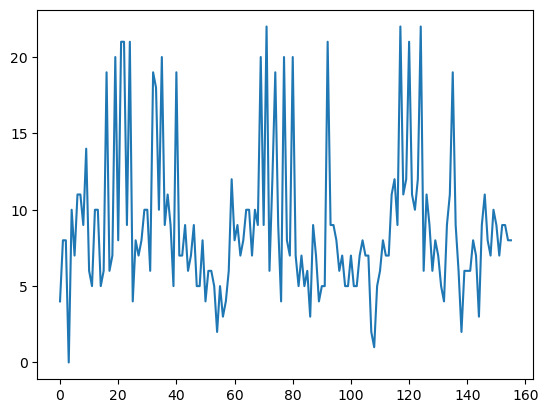

In [47]:
plt.plot(range(len(submission['total_cases'])), submission['total_cases'])
plt.show()

In [48]:
submission.to_csv('sj_XGBoost_predictions.csv')